Skipping .ipynb_checkpoints: [Errno 13] Permission denied: 'C:\\Users\\Dell\\CampusX_100 days of ML\\selectedimages\\.ipynb_checkpoints'


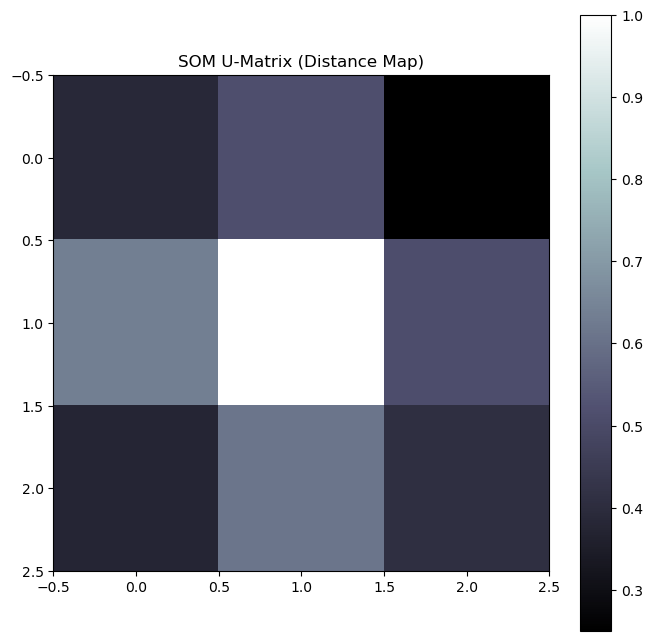

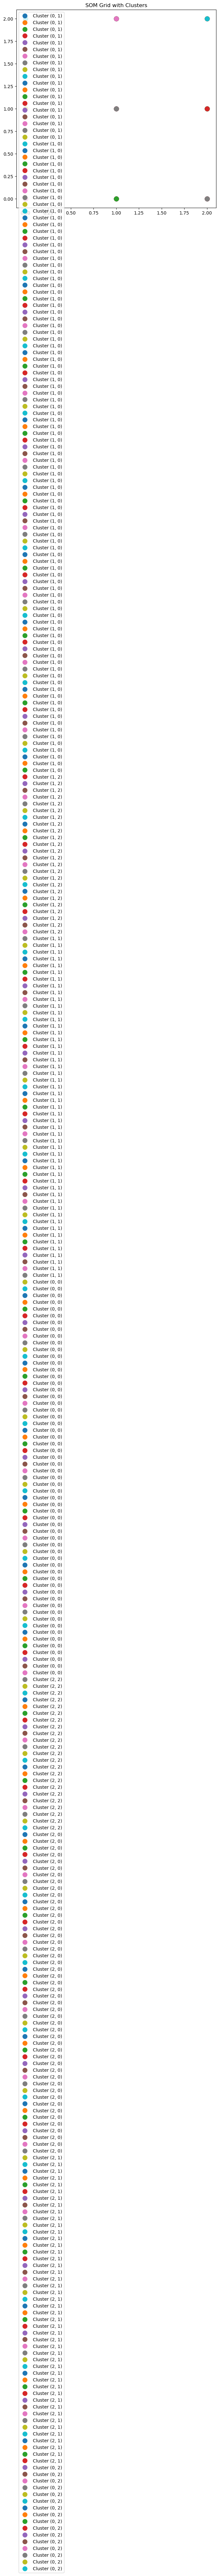

Total clusters: 9
Cluster (0, 1): 19 images
Cluster (1, 0): 94 images
Cluster (1, 2): 24 images
Cluster (1, 1): 51 images
Cluster (0, 0): 59 images
Cluster (2, 2): 23 images
Cluster (2, 0): 48 images
Cluster (2, 1): 46 images
Cluster (0, 2): 16 images
Topographic Error: 0.021052631578947368
Clustered images saved to FinalClusteredImages1


In [15]:


import os
import numpy as np
from PIL import Image
from minisom import MiniSom
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import shutil

# Step 1: Load and preprocess images
def load_images_from_folder(folder, resize=(64, 64)):
    images = []
    filenames = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        try:
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = img.resize(resize)  # Resize image
            img_array = np.array(img).flatten()  # Flatten to 1D array
            images.append(img_array)
            filenames.append(filename)
        except Exception as e:
            print(f"Skipping {filename}: {e}")
    return np.array(images), filenames

# Step 2: Normalize the data
def normalize_data(data):
    scaler = MinMaxScaler()
    return scaler.fit_transform(data)

# Step 3: Train the SOM
def train_som(data, som_shape=(10, 10), sigma=1.0, learning_rate=0.5, num_iterations=100):
    som = MiniSom(som_shape[0], som_shape[1], data.shape[1], sigma=sigma, learning_rate=learning_rate)
    som.random_weights_init(data)
    som.train_random(data, num_iterations)
    return som

# Step 4: Visualize SOM grid
def plot_som_grid(som):
    plt.figure(figsize=(8, 8))
    plt.imshow(som.distance_map().T, cmap='bone')  # Use the 'bone' colormap for the U-matrix
    plt.colorbar()
    plt.title("SOM U-Matrix (Distance Map)")
    plt.show()

# Step 5: Visualize the clusters in SOM
def plot_som_clusters(som, data, clusters):
    plt.figure(figsize=(8, 8))
    for cluster_id, image_indices in clusters.items():
        for idx in image_indices:
            winner = som.winner(data[idx])
            plt.plot(winner[0], winner[1], 'o', markersize=10, label=f"Cluster {cluster_id}")
    plt.legend()
    plt.title("SOM Grid with Clusters")
    plt.show()

# Step 6: Cluster the images
def cluster_images(som, data):
    clusters = {}
    for i, img in enumerate(data):
        winner = som.winner(img)
        if winner not in clusters:
            clusters[winner] = []
        clusters[winner].append(i)
    return clusters

# Step 7: Visualize all clusters in a single large image
def visualize_all_clusters(clusters, images, filenames, resize_shape=(64, 64), spacing=10):
    # Calculate the size of the canvas
    max_images_per_cluster = max(len(indices) for indices in clusters.values())
    rows = len(clusters)  # Number of clusters
    cols = max_images_per_cluster  # Maximum images in any cluster
    
    # Calculate canvas size
    canvas_width = cols * (resize_shape[0] + spacing) + spacing
    canvas_height = rows * (resize_shape[1] + spacing) + spacing
    canvas = Image.new('L', (canvas_width, canvas_height), color=255)  # White background
    
    # Paste images into the canvas, grouped by cluster
    for row, (cluster_id, image_indices) in enumerate(clusters.items()):
        for col, idx in enumerate(image_indices):
            img = Image.fromarray(images[idx].reshape(resize_shape))
            x = col * (resize_shape[0] + spacing) + spacing
            y = row * (resize_shape[1] + spacing) + spacing
            canvas.paste(img, (x, y))
    
    # Display the canvas
    canvas.show(title="All Clusters")
    # Optionally, save the canvas
    canvas.save("all_clusters.png")

# Step 8: Save clustered images into separate folders
def save_clusters_to_folders(clusters, images, filenames, output_dir="FinalClusteredImages2"):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Create directories for each cluster and move the corresponding images
    for cluster_id, image_indices in clusters.items():
        cluster_folder = os.path.join(output_dir, f"cluster_{cluster_id}")
        if not os.path.exists(cluster_folder):
            os.makedirs(cluster_folder)
        
        for idx in image_indices:
            # Save each image in the respective cluster folder
            img = Image.fromarray(images[idx].reshape(64, 64))  # Reshape to original size (e.g., 64x64)
            img.save(os.path.join(cluster_folder, filenames[idx]))
    
    print(f"Clustered images saved to {output_dir}")

# Step 9: Model Performance Metrics
def topographic_error(som, data):
    error = 0
    for x in data:
        bmu = som.winner(x)
        distances = np.linalg.norm(som.get_weights() - x, axis=2)
        sorted_indices = np.unravel_index(np.argsort(distances, axis=None), distances.shape)
        bmu1 = sorted_indices[0][0], sorted_indices[1][0]
        bmu2 = sorted_indices[0][1], sorted_indices[1][1]
        if not (abs(bmu1[0] - bmu2[0]) <= 1 and abs(bmu1[1] - bmu2[1]) <= 1):
            error += 1
    return error / len(data)

# Main function
def main():
    folder = "selectedimages/"  # Replace with your folder path
    images, filenames = load_images_from_folder(folder)
    normalized_images = normalize_data(images)
    
    # Define SOM parameters
    som_shape = (3,3)  # 1x8 grid for 8 clusters
    sigma = 0.5
    learning_rate = 0.1
    num_iterations = 10000
    
    # Train the SOM
    som = train_som(normalized_images, som_shape, sigma, learning_rate, num_iterations)
    
    # Plot the U-matrix to visualize SOM grid
    plot_som_grid(som)
   
    # Cluster the images
    clusters = cluster_images(som, normalized_images)
    
    # Visualize the SOM grid with clusters
    plot_som_clusters(som, normalized_images, clusters)
    
    # Print cluster information
    print(f"Total clusters: {len(clusters)}")
    for cluster_id, image_indices in clusters.items():
        print(f"Cluster {cluster_id}: {len(image_indices)} images")
    
    # Calculate and print model performance metrics
    te = topographic_error(som, normalized_images)
    print(f"Topographic Error: {te}")
    
    # Visualize all clusters in a single large image
    visualize_all_clusters(clusters, images, filenames)
    
    # Save the clustered images into separate folders
    save_clusters_to_folders(clusters, images, filenames)

if __name__ == "__main__":
    main()